<a href="https://colab.research.google.com/github/Vera-Emelianenko/BI_ML_2021/blob/hw_cnn/hw_cnn/hw_cnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$: 
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F) 
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [2]:
import torch
import numpy as np

In [3]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [6]:
def conv(x, kernel, stride, pad):
    if type(kernel).__name__!='ndarray':
        kernel = kernel.numpy()
    # define parameters 
    w = x.shape[0]
    h = x.shape[1]
    k = kernel.shape[0]

    # this is not the actual width of the output image, 
    # it's width - padding, I will add padding later
    w_out = int(1 + (w - k)/stride)
    h_out = int(1 + (h - k)/stride)
    img_out = np.zeros(shape=(w_out, h_out))
    for row in range (0, h_out, stride):
      for column in range (0, w_out, stride):
        submatrix = x[row:row+k, column:column+k]
        multiplied = np.multiply(submatrix,kernel)
        img_out[row, column] = np.sum(multiplied)
    result = np.pad(img_out, pad_width = pad)
    return result

sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])
conv(x = M, kernel=sobel_kernel_vert, stride=1, pad=1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8., -4., -4.,  8.,  0.],
       [ 0.,  8., -4., -4.,  8.,  0.],
       [ 0.,  8., -4., -4.,  8.,  0.],
       [ 0.,  8., -4., -4.,  8.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

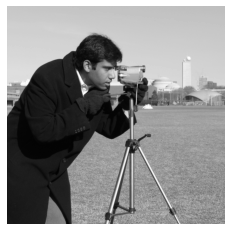

In [8]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

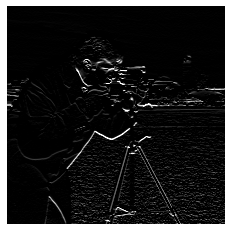

In [10]:
camera_s_hor_filter = conv(camera, kernel=sobel_kernel_hor, stride=1, pad=0)
plt.figure()
plt.imshow(camera_s_hor_filter.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

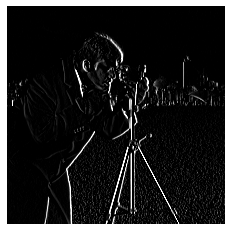

In [9]:
camera_s_vert_filter = conv(camera, kernel=sobel_kernel_vert, stride=1, pad=0)
plt.figure()
plt.imshow(camera_s_vert_filter.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Допишите код ниже и проинтерпретируйте полученный результат:

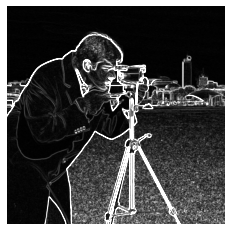

In [12]:
camera_s_hor_filter = conv(camera, kernel=sobel_kernel_hor, stride=1, pad=0)
camera_s_vert_filter = conv(camera, kernel=sobel_kernel_vert, stride=1, pad=0)
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Для получения картинки со всеми выделенными границами две отфильтрованные картинки объединяются, причёт так, что значение каждого пикселя - это квадратный корень из суммы квадратов значений этого пикселя в "вертикальной" и "горизонтальной" картинках. Почему именно квадратный корень, а не, непример, среднее, я не уверена.  

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [66]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 15 # можно будет при желании увеличить
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [16]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [18]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        
        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]
        
        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [20]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
trainloader

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

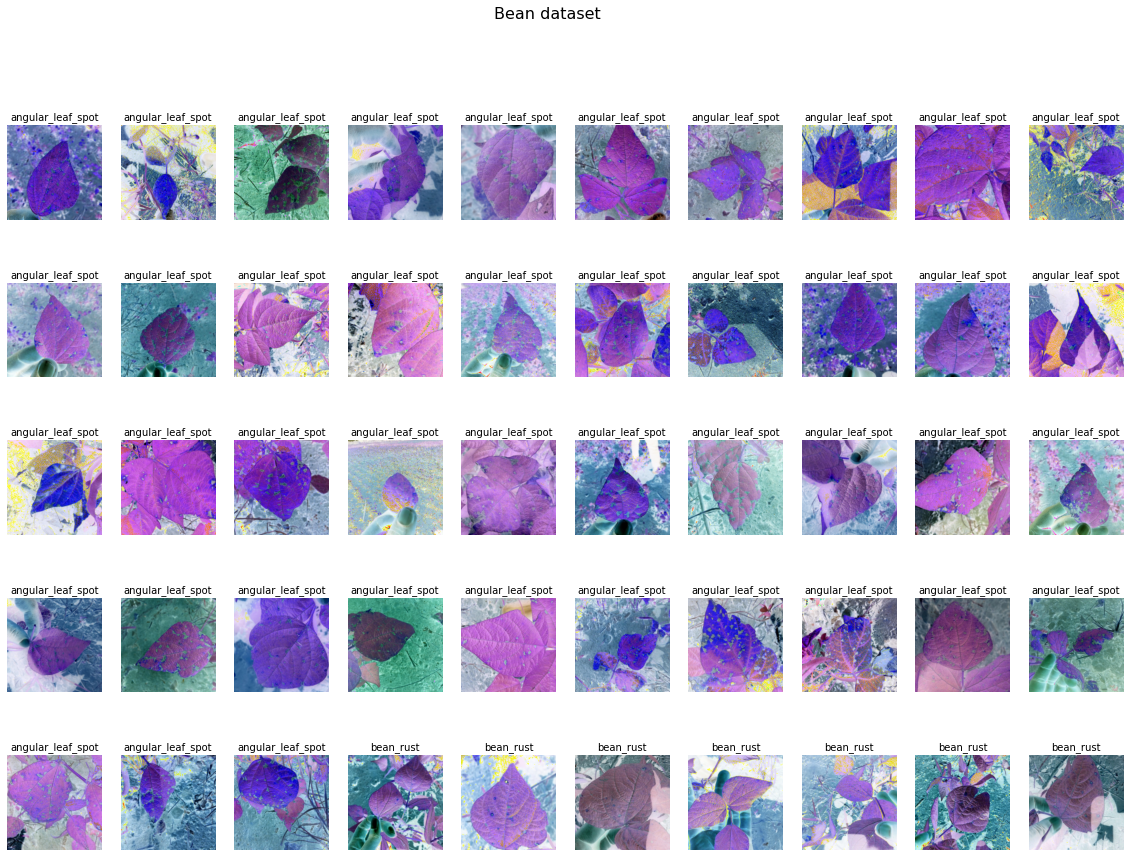

In [22]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

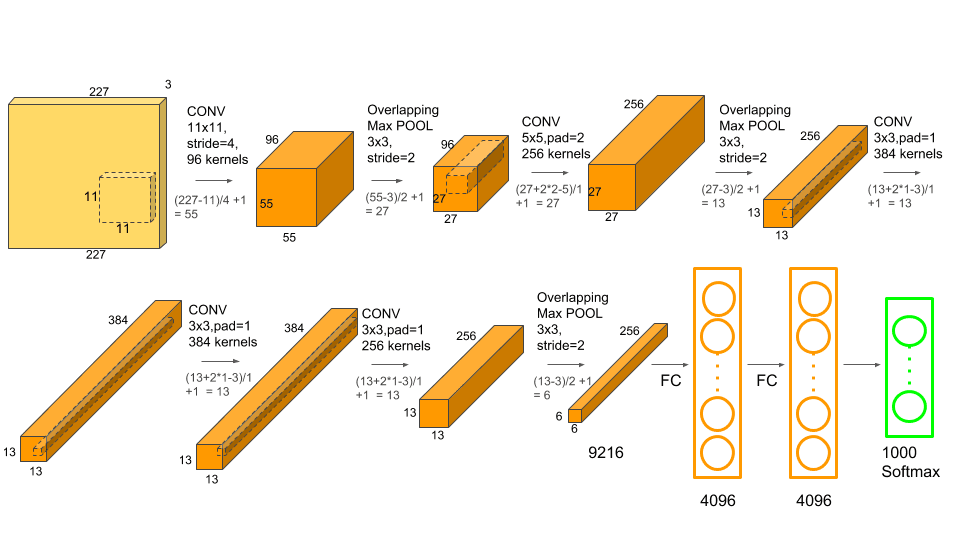

In [27]:
!ls train

angular_leaf_spot  bean_rust  healthy


In [67]:
N_CLASSES = 3 # angular_leaf_spot  bean_rust  healthy 
LEARNING_RATE = 2e-4 # можно подобрать как-то другой)

In [68]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096), 
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=3)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [69]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [70]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

16:52:07 --- Epoch: 0	Train loss: 1.0950	Valid loss: 1.0724	Train accuracy: 46.13	Valid accuracy: 42.86
16:52:47 --- Epoch: 1	Train loss: 0.9934	Valid loss: 0.8508	Train accuracy: 65.57	Valid accuracy: 63.16
16:53:26 --- Epoch: 2	Train loss: 0.8471	Valid loss: 0.7838	Train accuracy: 69.83	Valid accuracy: 69.92
16:54:06 --- Epoch: 3	Train loss: 0.7196	Valid loss: 0.7604	Train accuracy: 70.79	Valid accuracy: 70.68
16:54:45 --- Epoch: 4	Train loss: 0.6969	Valid loss: 0.6940	Train accuracy: 73.11	Valid accuracy: 72.18
16:55:26 --- Epoch: 5	Train loss: 0.7049	Valid loss: 0.7187	Train accuracy: 69.83	Valid accuracy: 66.17
16:56:07 --- Epoch: 6	Train loss: 0.6263	Valid loss: 0.5870	Train accuracy: 75.92	Valid accuracy: 77.44
16:56:47 --- Epoch: 7	Train loss: 0.6014	Valid loss: 0.6488	Train accuracy: 75.34	Valid accuracy: 75.19
16:57:27 --- Epoch: 8	Train loss: 0.5762	Valid loss: 0.6665	Train accuracy: 75.53	Valid accuracy: 75.19
16:58:06 --- Epoch: 9	Train loss: 0.5999	Valid loss: 0.5717	Trai

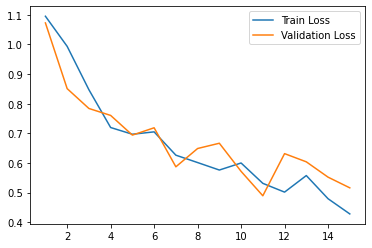

In [71]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

Максимальная accuracy была 80.45 % при LEARNING_RATE = 3e-4 и 81.20 при LEARNING_RATE = 2e-4 и 15 эпохах.

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

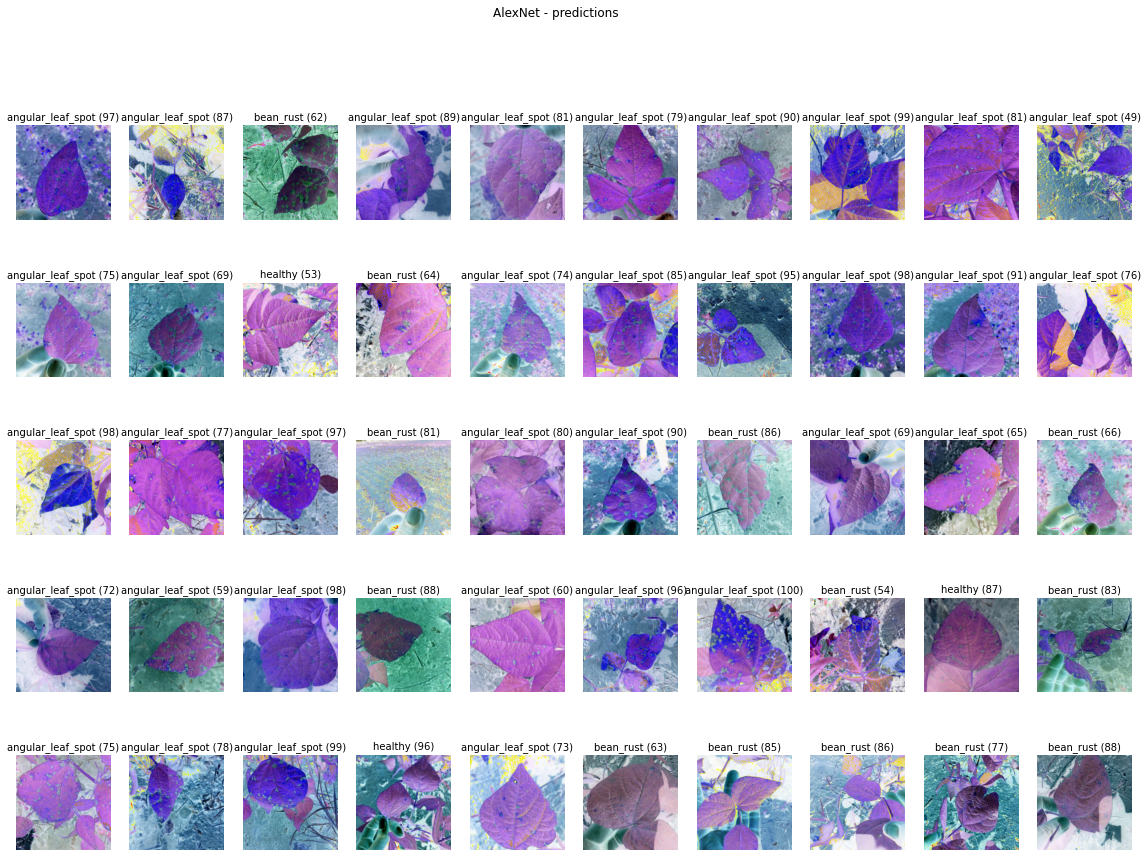

In [72]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

Качество модели не очень хорошее, она ошибается в 20% случаях и не очень уверена в своих предсказаниях (хотя в некоторых очень уверена). 

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**